In [10]:
using Pkg

Pkg.activate("..")

using CairoMakie
using Distributions, LinearAlgebra, Random, StatsBase

include("../Code/GLV.jl")

  Activating project at `~/Projects/Working/PhD/TempFeas`


Main.GLV

In [11]:
Random.seed!(1)
dK = LogNormal(0.0,0.447)
daij = LogNormal(-4.0,0.447)
daii = LogNormal(0.0,0.447)

GLV.richness(0.5, daij, daii, dK)


27.9

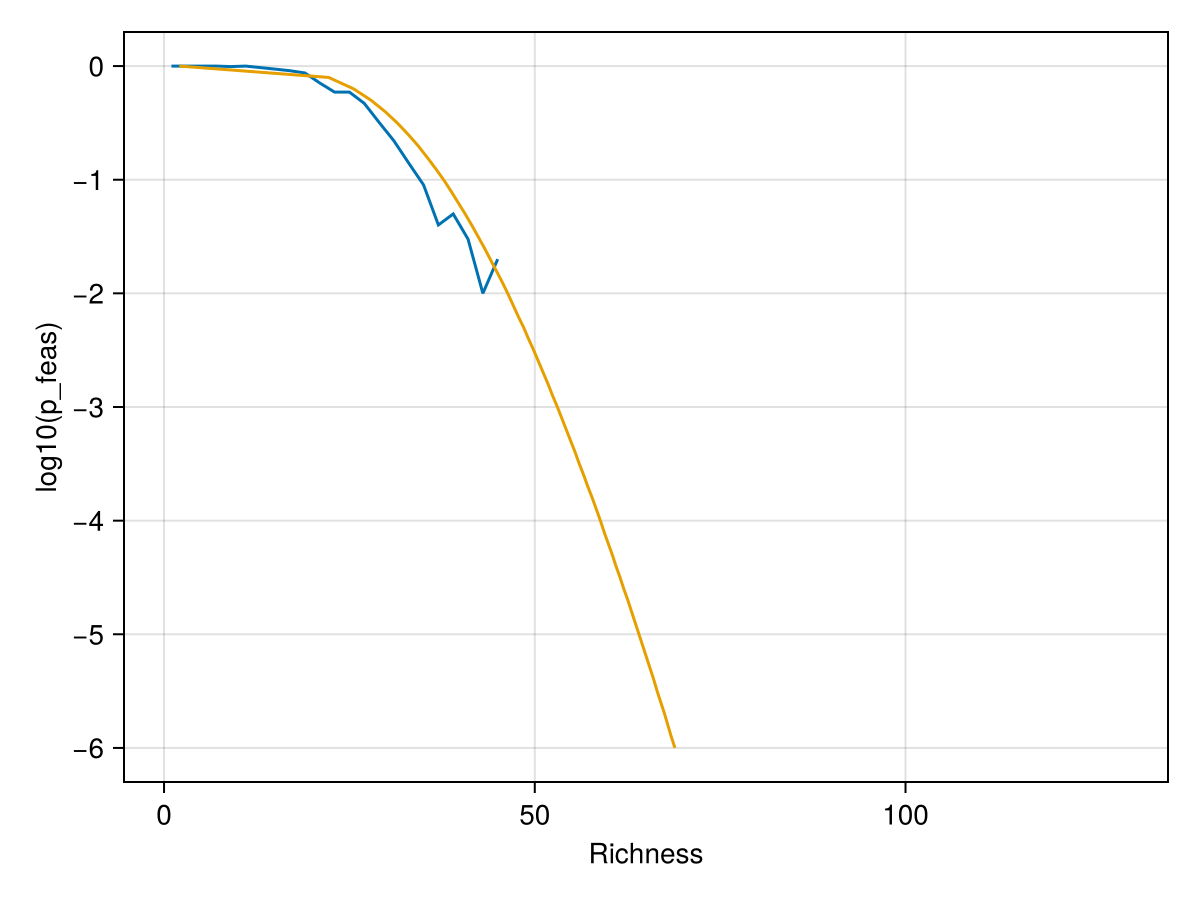

In [12]:
Random.seed!(1)
dr = LogNormal(0.0,0.447)
daij = LogNormal(-5.0,0.447)
daii = LogNormal(-1.0,0.447)

#r' cdf
cdf_r_norm(x) = cdf(LogNormal(dr.σ^2  / 2, dr.σ),x)

# #generate systems of N size
N_max = ceil(GLV.richness(1e-5, daij, daii, dr))
N_vec = Int.(1:2:(N_max*2))

rep = 100
res = zeros(rep,length(N_vec))

for i = 1:rep
    for (j,N) = enumerate(N_vec)
#         #make system
        r = rand(dr, N)
        a = rand(daij, N, N)
        [a[k,k] = rand(daii) for k = 1:N]

        x = inv(a) * r

        res[i,j] = all(x .> 0)

    end
end

res

# #predictions
p_vec = 10 .^ (-6:0.1:0.0)
N_vec_pred = GLV.richness.(p_vec, Ref(daij), Ref(daii), Ref(dr))

# #plot
f = Figure()
ax = Axis(f[1,1], xlabel = "Richness", ylabel = "log10(p_feas)")
CairoMakie.lines!(ax, N_vec,log10.(mean(res,dims = 1)[:]), label = "simualted")
CairoMakie.lines!(ax, N_vec_pred, log10.(p_vec), label = "predicted")
# axislegend(ax)
f


# Temperature

In [70]:
#predict richness from distributions
function pred_richness(r, aij, aii, T_vec, N_rep, prob)
    #allocate results arrays
    simulated_richness = Array{Float64}(undef, length(T_vec))
    predicted_richness = zeros(length(T_vec))

    for (i,T) = enumerate(T_vec)
        #get trait Distributions from parameters
        dr, daij, daii = GLV.trait_temp(r, T), GLV.trait_temp(aij, T), GLV.trait_temp(aii, T)
        
        #predicted
        predicted_richness[i] = GLV.richness(prob, daij, daii, dr)
        N = Int(ceil(predicted_richness[i]))
        
        N_vec = max(N-5,1):(N+5)
        # #generators
        f_r(x...) = rand(dr, x...)
        f_aij(x...) = rand(daij, x...)
        f_aii(x...) = rand(daii, x...)

        #loop over Nvals
        p_feas = zeros(length(N_vec))
        for (k,N) = enumerate(N_vec)
            feas_vec = zeros(N_rep)
            Threads.@threads for j = 1:N_rep
                #generate params
                r_ = f_r(N)
                a_ = f_aij(N,N)
                [a_[ii,ii] = f_aii(1)[1] for ii = 1:N]
                #make params
                x = inv(a_) * r_ 
                feas_vec[j] = all(x .> 0)
            end
            p_feas[k] = mean(feas_vec)
        end
        #get bounds on richness
        N_indx = findmin(abs.(p_feas .- prob))
        simulated_richness[i] = N_vec[N_indx[2]]
    end
    return(simulated_richness, predicted_richness)
end

pred_richness (generic function with 1 method)

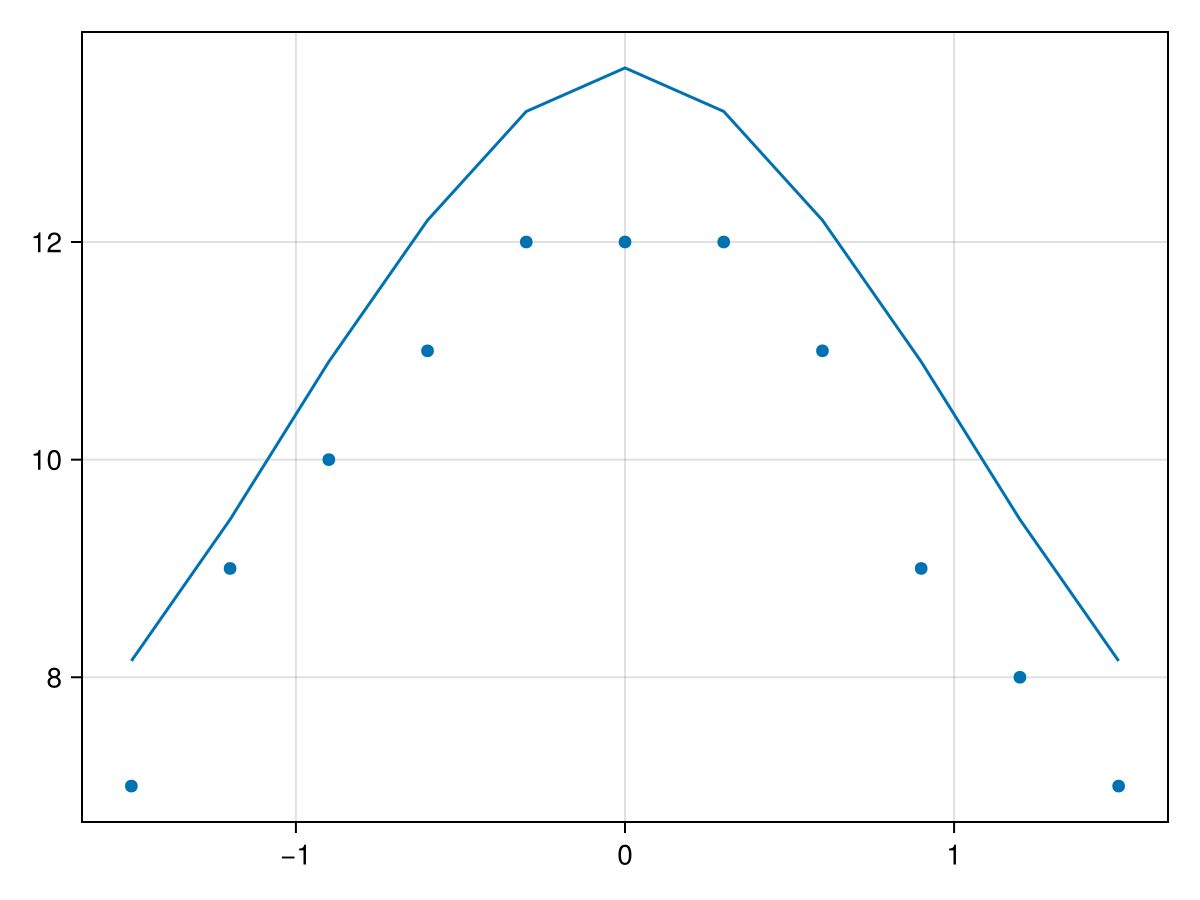

In [71]:
#inital test
r = Dict(:uB0 => 0.0, :vB0 => 0.2, :uE => 0.6, :vE => 0.1, :Σ => 0.0)
aij = Dict(:uB0 => -6.0, :vB0 => 0.2, :uE => 0.6, :vE => 0.1, :Σ => 0.0)
aii = Dict(:uB0 => -3.0, :vB0 => 0.2, :uE => 0.6, :vE => 0.001, :Σ => 0.0)

T_vec = -1.5:0.3:1.5

sim, pred = pred_richness(r, aij, aii, T_vec, 500, 0.5)

f = Figure()
ax = Axis(f[1,1])
scatter!(ax, T_vec, sim)
lines!(ax, T_vec, pred)
f

# Predict over variables

In [74]:
N_rep = 100
prob = 0.5
T_vec = -1.5:0.05:1.5

-1.5:0.05:1.5

## Mean

In [75]:
r = Dict(:uB0 => 0.0, :vB0 => 0.1, :uE => 0.3, :vE => 0.02, :Σ => 0.0)
aij = Dict(:uB0 => -8, :vB0 => 0.1, :uE => 1.2, :vE => 0.02, :Σ => 0.0)
aii = Dict(:uB0 => -4, :vB0 => 0.1, :uE => 0.6, :vE => 0.02, :Σ => 0.0)

#mean
sim_μ_1,pred_μ_1 = pred_richness(r,aij,aii,T_vec,N_rep,prob)

aij[:uE] = 0.6
sim_μ_2,pred_μ_2 = pred_richness(r,aij,aii,T_vec,N_rep,prob)

aij[:uE] = 0.0
sim_μ_3,pred_μ_3 = pred_richness(r,aij,aii,T_vec,N_rep,prob)

([71.0, 70.0, 70.0, 66.0, 68.0, 68.0, 67.0, 64.0, 67.0, 64.0  …  23.0, 23.0, 20.0, 20.0, 19.0, 20.0, 18.0, 18.0, 16.0, 15.0], [72.5, 71.9, 71.3, 70.7, 70.05, 69.4, 68.75, 68.0, 67.3, 66.55  …  24.9, 24.05, 23.25, 22.45, 21.7, 20.95, 20.25, 19.5, 18.85, 18.2])

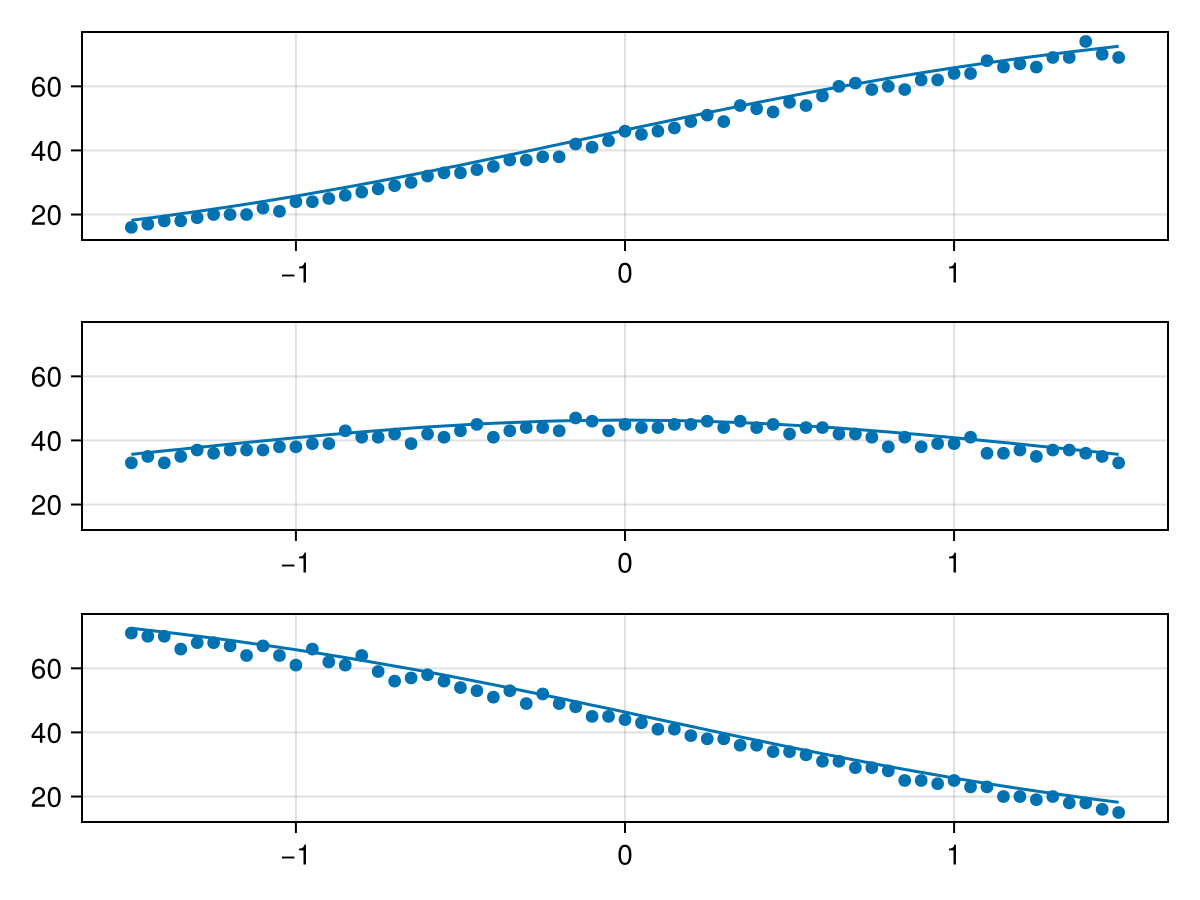

In [76]:
f = Figure()
ax = Axis(f[1,1])
scatter!(ax, T_vec, sim_μ_1)
lines!(ax, T_vec, pred_μ_1)

ax = Axis(f[2,1])
scatter!(ax, T_vec, sim_μ_2)
lines!(ax, T_vec, pred_μ_2)

ax = Axis(f[3,1])
scatter!(ax, T_vec, sim_μ_3)
lines!(ax, T_vec, pred_μ_3)

linkyaxes!(f.content...)

f

## variance

In [19]:
r = Dict(:uB0 => 0.0, :vB0 => 0.1, :uE => 0.3, :vE => 0.02, :Σ => 0.0)
aij = Dict(:uB0 => -8, :vB0 => 0.1, :uE => 0.6, :vE => 0.02, :Σ => 0.0)
aii = Dict(:uB0 => -4, :vB0 => 0.1, :uE => 0.6, :vE => 0.02, :Σ => 0.0)

#mean
sim_σ_1,pred_σ_1 = pred_richness(r,aij,aii,T_vec,N_rep,prob)

r[:vE] = 0.2
aij[:vE] = 0.2
aii[:vE] = 0.2
sim_σ_2,pred_σ_2 = pred_richness(r,aij,aii,T_vec,N_rep,prob)

([11.0, 11.0, 12.0, 13.0, 12.0, 13.0, 14.0, 16.0, 15.0, 16.0  …  17.0, 16.0, 15.0, 14.0, 14.0, 12.0, 11.0, 12.0, 10.0, 10.0], [11.05, 11.7, 12.4, 13.15, 13.95, 14.75, 15.65, 16.6, 17.65, 18.7  …  18.7, 17.65, 16.6, 15.65, 14.75, 13.95, 13.15, 12.4, 11.7, 11.05])

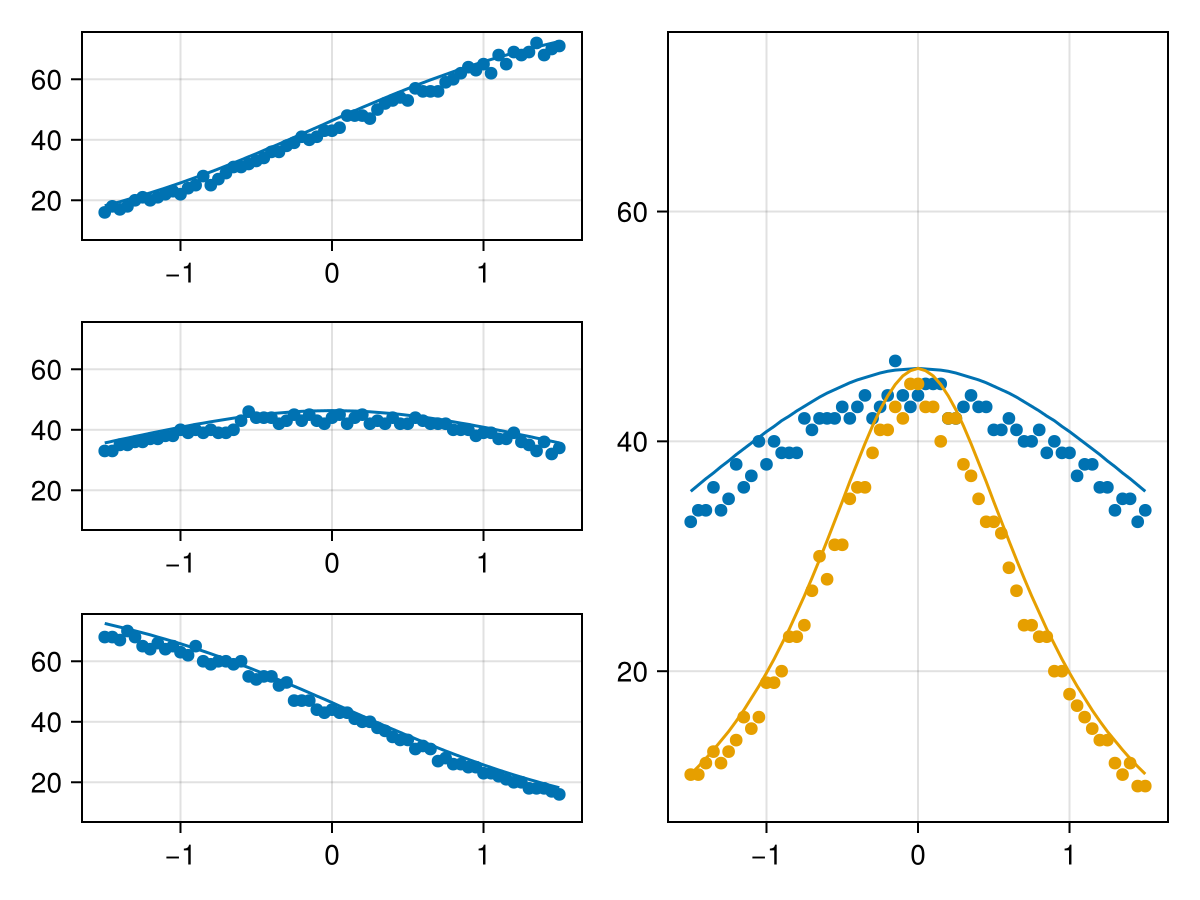

In [20]:
ax = Axis(f[1:3,2])
scatter!(ax, T_vec, sim_σ_1)
lines!(ax, T_vec, pred_σ_1)

scatter!(ax, T_vec, sim_σ_2)
lines!(ax, T_vec, pred_σ_2)


linkyaxes!(f.content...)

f

## Covariance

In [21]:
r = Dict(:uB0 => 0.0, :vB0 => 0.1, :uE => 0.3, :vE => 0.2, :Σ => 0.0)
aij = Dict(:uB0 => -8, :vB0 => 0.1, :uE => 0.6, :vE => 0.2, :Σ => 0.0)
aii = Dict(:uB0 => -4, :vB0 => 0.1, :uE => 0.6, :vE => 0.2, :Σ => 0.0)

#mean
sim_Σ_1,pred_Σ_1 = pred_richness(r,aij,aii,T_vec,N_rep,prob)

r[:Σ] = -0.1
aij[:Σ] = -0.1
aii[:Σ] = -0.1
sim_Σ_2,pred_Σ_2 = pred_richness(r,aij,aii,T_vec,N_rep,prob)

([22.0, 23.0, 24.0, 27.0, 28.0, 29.0, 34.0, 36.0, 38.0, 40.0  …  11.0, 10.0, 10.0, 9.0, 7.0, 8.0, 8.0, 7.0, 7.0, 7.0], [23.25, 24.85, 26.6, 28.5, 30.55, 32.75, 35.1, 37.65, 40.35, 43.25  …  11.45, 10.8, 10.15, 9.55, 9.05, 8.5, 8.05, 7.6, 7.15, 6.8])

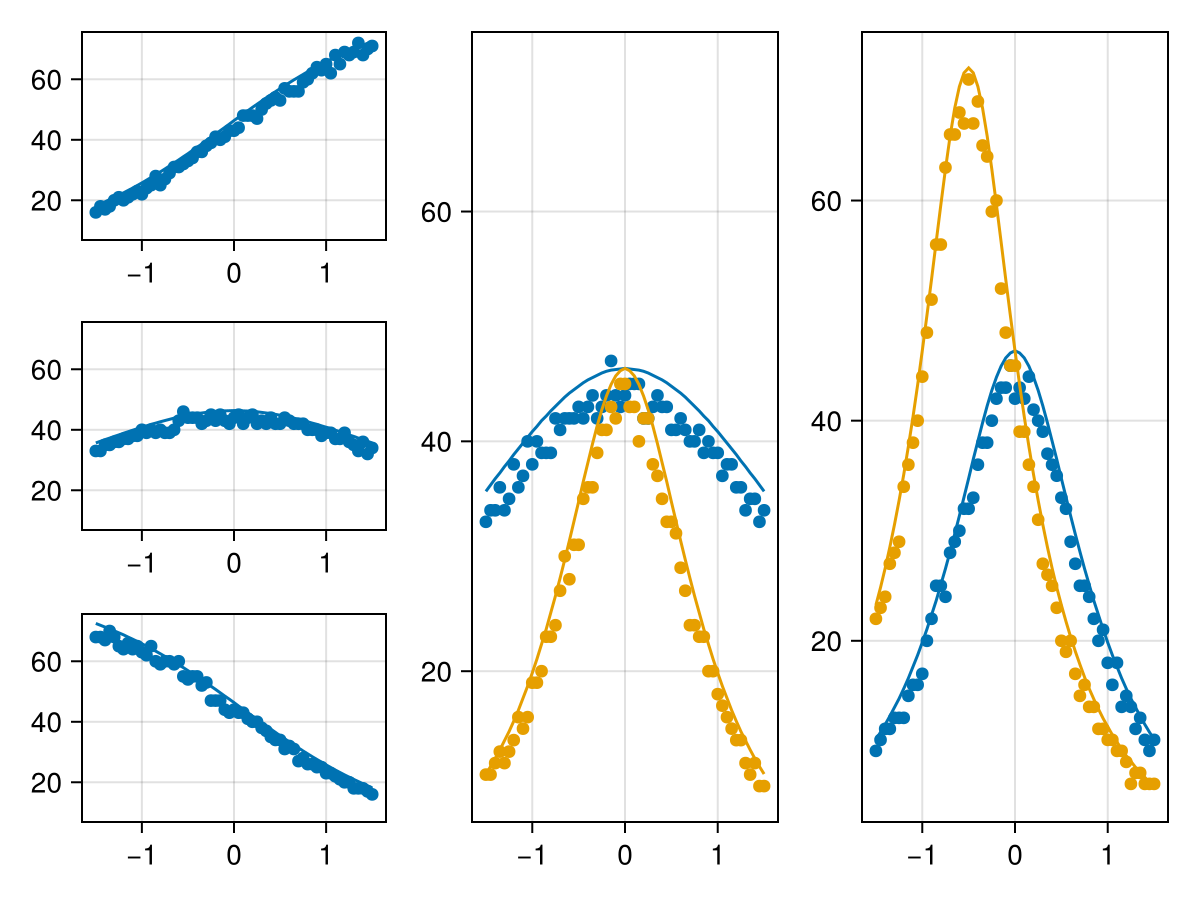

In [22]:
ax = Axis(f[1:3,3])
scatter!(ax, T_vec, sim_Σ_1)
lines!(ax, T_vec, pred_Σ_1)

scatter!(ax, T_vec, sim_Σ_2)
lines!(ax, T_vec, pred_Σ_2)


# linkyaxes!(f.content...)

f

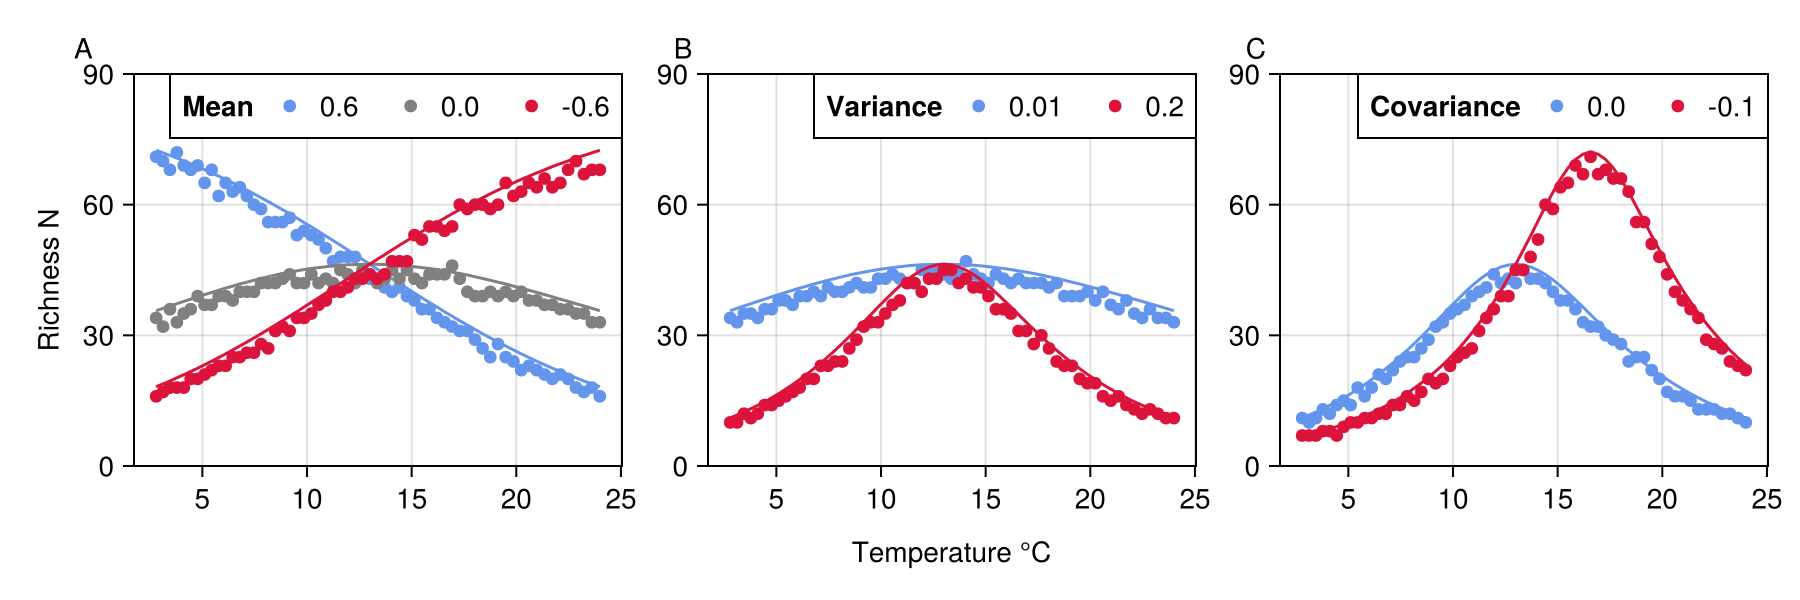

In [23]:
f = Figure(size = (900,300))

# ylims!(ax[3],(0,40))


T_plot = GLV.ΔT_to_C.(T_vec,13.0)

#mean
# subgl_mean = GridLayout()
ax1 = Axis(f[1,1])


scatter!(ax1, T_plot, sim_μ_1, color = "cornflowerblue", label = "0.6")
lines!(ax1, T_plot, pred_μ_1, color = "cornflowerblue")
scatter!(ax1, T_plot, sim_μ_2, color = "grey", label = "0.0")
lines!(ax1, T_plot, pred_μ_2, color = "grey")
scatter!(ax1, T_plot, sim_μ_3, color = "crimson", label = "-0.6")
lines!(ax1, T_plot, pred_μ_3, color = "crimson")

#var
ax2 = Axis(f[1,2])

scatter!(ax2, T_plot, sim_σ_1, color = "cornflowerblue", label = "0.01")
lines!(ax2, T_plot, pred_σ_1, color = "cornflowerblue")
scatter!(ax2, T_plot, sim_σ_2, color = "crimson", label = "0.2")
lines!(ax2, T_plot, pred_σ_2, color = "crimson")

#cov
ax3 = Axis(f[1,3])

scatter!(ax3, T_plot, sim_Σ_1, color = "cornflowerblue", label = "0.0")
lines!(ax3, T_plot, pred_Σ_1, color = "cornflowerblue")
scatter!(ax3, T_plot, sim_Σ_2, color = "crimson", label = "-0.1")
lines!(ax3, T_plot, pred_Σ_2, color = "crimson")

f[1,1] = Legend(f, ax1, "Mean", tellwidth = false, tellheight = false,  halign = :right, valign = :top, orientation = :horizontal, titleposition = :left)
f[1,2] = Legend(f, ax2, "Variance", tellwidth = false, tellheight = false, halign = :right, valign = :top, orientation = :horizontal, titleposition = :left)
f[1,3] = Legend(f, ax3, "Covariance", tellwidth = false, tellheight = false, halign = :right, valign = :top, orientation = :horizontal, titleposition = :left)

Label(f[1,1:3,Bottom()], "Temperature °C", padding = (0,0,0,35))
Label(f[1,1,Left()], "Richness N", padding = (0,35,0,10), rotation = 3.14 / 2)

Label(f[1,1,TopLeft()], "A",padding = (0.0,0.0,5,0.0))
Label(f[1,2,TopLeft()], "B",padding = (0.0,0.0,5,0.0))
Label(f[1,3,TopLeft()], "C",padding = (0.0,0.0,5,0.0))

ylims!.([ax1,ax2,ax3],0,90)
linkyaxes!(ax1,ax2,ax3)


f

In [17]:
save("../docs/Figures/LV_sims.pdf", f)

CairoMakie.Screen{PDF}


# Sensitvity Analysis

In [201]:
function getRMSE(r,aij,aii,T_vec,N_rep,prob)
    s,p = pred_richness(r,aij,aii,T_vec,N_rep,prob)
    sqrt(mean((s .- p) .^ 2) / mean(s))
end

function random_params()
    
    r = Dict(:uB0 => rand(), :vB0 => 0.5rand(), :uE => rand(), :vE => rand(), :Σ => 0.0)
    r[:Σ] = (2 * (r[:vB0] * r[:vE]) * rand()) - (r[:vB0] * r[:vE])
    
    aij = Dict(:uB0 => -8.5 + rand(), :vB0 => 0.5rand(), :uE => rand(), :vE => rand(), :Σ => 0.0)
    aij[:Σ] = (2 * (aij[:vB0] * aij[:vE]) * rand()) - (aij[:vB0] * aij[:vE])
    
    aii = Dict(:uB0 => -4.5 + rand(), :vB0 => 0.5rand(), :uE => rand(), :vE => rand(), :Σ => 0.0)
    aii[:Σ] = (2 * (aii[:vB0] * aii[:vE]) * rand()) - (aii[:vB0] * aii[:vE])

    return(r,aij,aii)
end

random_params (generic function with 1 method)

In [243]:
Nrep = 10000

#params
kp = [:uB0,:vB0,:uE,:vE,:Σ]
rp = zeros(Nrep, 5)
aijp = zeros(Nrep, 5)
aiip = zeros(Nrep, 5)

err = zeros(Nrep)

k = [0]

Threads.@threads for i = 1:Nrep
    k[1] += 1
    print("\r", k[1])
    r,aij,aii = random_params()

    rp[i,:] .= [r[k_] for k_ = kp]
    aijp[i,:] .= [aij[k_] for k_ = kp]
    aiip[i,:] .= [aii[k_] for k_ = kp]
    
    try
        err[i] = getRMSE(r,aij,aii,T_vec,1,0.5)
    catch e
        # println("0")
    end
end

9994

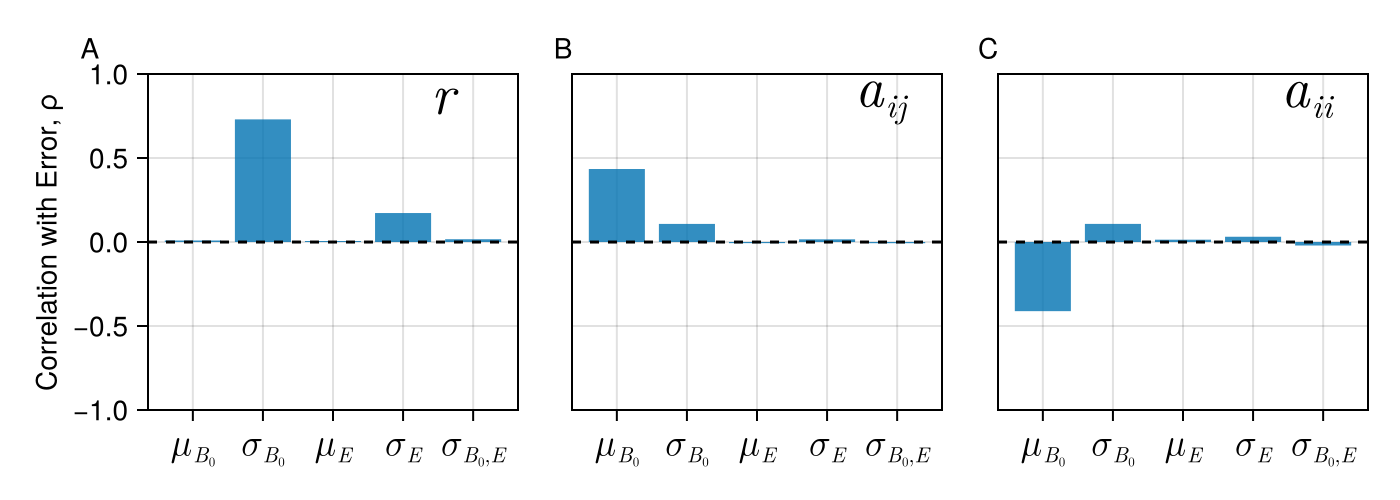

In [255]:
# p_mat = hcat(rp,aijp,aiip)
cor_vec = [[cor(x[:,i],err) for i = 1:5] for x = [rp,aijp,aiip]]

kplot = [L"\mu_{B_0}",L"\sigma_{B_0}",L"\mu_{E}",L"\sigma_{E}",L"\sigma_{B_0,E}"]

f = Figure(size = (700,250))
ax = [Axis(f[1,i], xticks = (1:15, string.(vcat(kplot,kplot,kplot))), xticklabelsize = 18) for i = 1:3]
ax[1].ylabel = "Correlation with Error, ρ"
barplot!.(ax, Ref(1:5), cor_vec)
hlines!.(ax,[0.0], linestyle = :dash, color = :black)

text!(ax[1],4.4,0.7,text = L"r", fontsize = 28)
text!(ax[2],4.4,0.7,text = L"a_{ij}", fontsize = 28)
text!(ax[3],4.4,0.7,text = L"a_{ii}", fontsize = 28)

Label(f[1,1,TopLeft()], "A",padding = (0.0,0.0,5,0.0))
Label(f[1,2,TopLeft()], "B",padding = (0.0,0.0,5,0.0))
Label(f[1,3,TopLeft()], "C",padding = (0.0,0.0,5,0.0))

ylims!.(ax,-1,1)

hideydecorations!.(ax[2:3],grid = false)
linkyaxes!(ax...)

f

In [256]:
save("../docs/Figures/sens_sims.pdf", f)

CairoMakie.Screen{PDF}


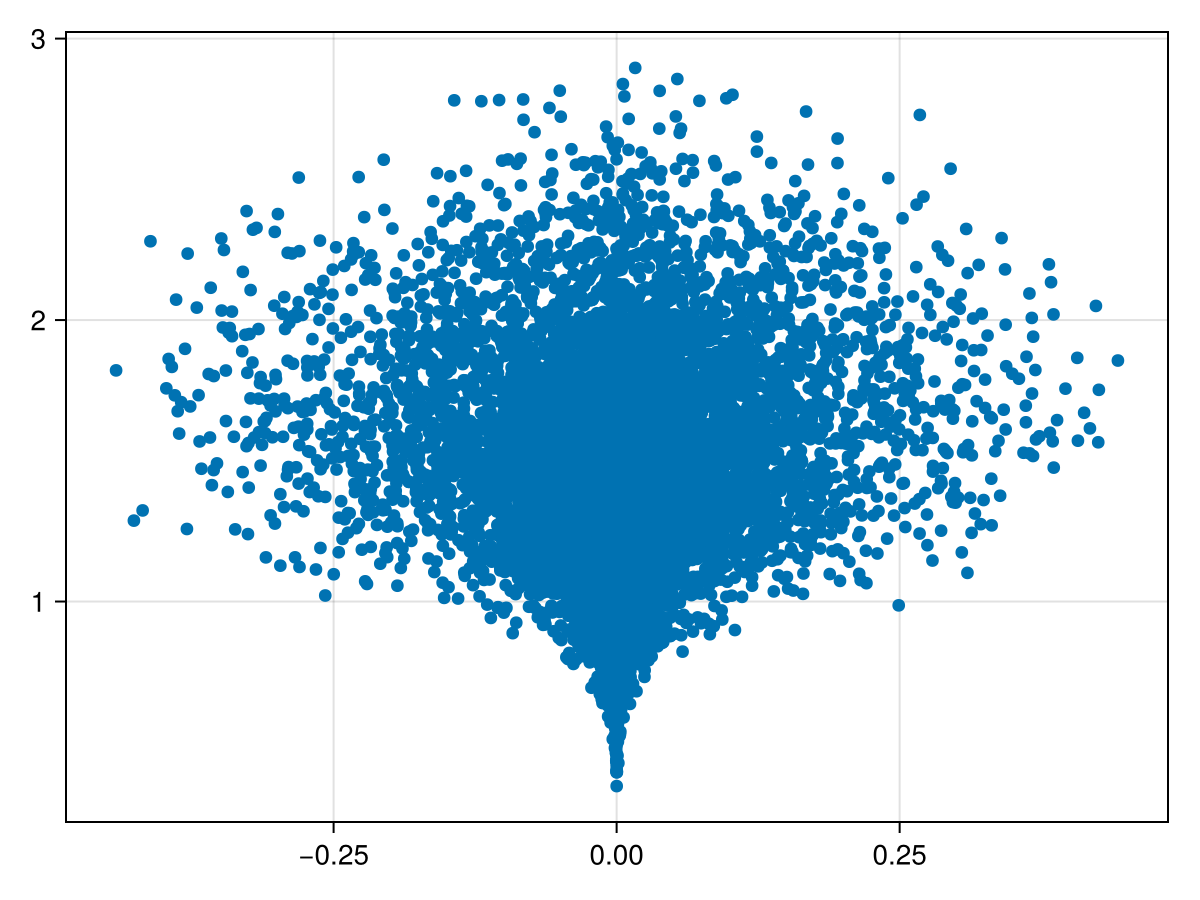

In [254]:
plot(rp[:,5],err)